# Analyze the data from the eclipse from CHEESE

## 1. Load all the necessary bits and pieces

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as pl
from matplotlib import colors
import os
from skimage.transform import rotate
from skimage.transform import rescale, resize, downscale_local_mean

from skimage.filters import unsharp_mask, gaussian
from skimage import exposure

import scipy.optimize as opt
import matplotlib as mp
from dataReductionSoftware import spectrum

import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting


def median_filter(image, filter_size):
    # Checking the filter size to ensure it's odd
    if filter_size % 2 == 0:
        raise ValueError("Filter size must be odd.")
    
    # Create a padded version of the input image
    pad_size = filter_size // 2
    padded_image = np.pad(image, pad_size, mode='edge')
    
    # Initialize the output image
    filtered_image = np.zeros_like(image)
    
    # Iterate over each pixel in the original image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract the region of interest using the current position and filter size
            roi = padded_image[i:i+filter_size, j:j+filter_size]
            
            # Compute the median of the region of interest
            median_value = np.median(roi)
            
            # Assign the median value to the corresponding pixel in the output image
            filtered_image[i, j] = median_value
    
    return filtered_image
    
def moving_average(a, n=3, threshold = 0.4, 
    backup_val = 0.5):
    len_A = len(a) 
    
    for el in range(len_A):
        if a[el] < threshold:
            a[el] = backup_val
        if a[el] > threshold:
            backup_val = a[el]
        
    # a = np.where(np.array(a) < 0.2, np.nan, a)
    
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



def polyfit2d(x, y, z, kx=3, ky=3, order=None):
    '''
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))
    
    
    From stack overflow: https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python
    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    '''

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)


Matplotlib created a temporary cache directory at /var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/matplotlib-2p1vheyj because the default path (/Users/memolnar/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## 2. Load the data 

*CHANGE* the dir location of all the data below:

In [4]:

data_dir = "/Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/real_data/"
darks_dir ="/Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/dark_data/"

files     = sorted(os.listdir(data_dir))

darks = sorted(os.listdir(darks_dir))
# cal_data = os.listdir(cal_dir)

num_files = len(files)
num_darks = len(darks)
# num_cal = len(cal_data)

print(f"Number of files:{num_files}, num darks: {num_darks}")

Number of files:6649, num darks: 1000


In [5]:
with fits.open(data_dir + files[0]) as hdul:
    print(f"Data shape is {hdul[0].data.shape}")
    print(hdul.info())
    nx = hdul[0].data.shape[0]
    ny = hdul[0].data.shape[1]
    print(hdul[0].header)
    
data_array = np.zeros((num_files, nx, ny))


for el in range(num_files):
    with fits.open(data_dir + files[el]) as hdul:    
        data_array[el, :, :] = hdul[0].data[:, :, 0]

Data shape is (1024, 1280, 1)
Filename: /Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/real_data/eclipse_data_2_0000
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (1, 1280, 1024)   int16   
None
SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    3                                                  NAXIS1  =                    1                                                  NAXIS2  =                 1280                                                  NAXIS3  =                 1024                                                  DATAMIN =                    0                                                  DATAMAX =                 4095                                                  DATE    = '2024-04-08T11:45:08'                                                 DATE_O

In [6]:
with fits.open(darks_dir + darks[0]) as hdul:
    print(f"Data shape is {hdul[0].data.shape}")
    print(hdul.info())
    nx = hdul[0].data.shape[0]
    ny = hdul[0].data.shape[1]
    print(hdul[0].header)
    
darks_array = np.zeros((num_darks, nx, ny))


for el in range(num_darks):
    with fits.open(darks_dir + darks[el]) as hdul:    
        darks_array[el, :, :] = hdul[0].data[:, :, 0]

master_dark = np.median(darks_array, axis=0)

Data shape is (1024, 1280, 1)
Filename: /Users/memolnar/Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/dark_data/datal_dark_1_0000
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (1, 1280, 1024)   int16   
None
SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    3                                                  NAXIS1  =                    1                                                  NAXIS2  =                 1280                                                  NAXIS3  =                 1024                                                  DATAMIN =                    0                                                  DATAMAX =                 4095                                                  DATE    = '2024-04-08T12:27:42'                                                 DATE_OBS

Text(0.5, 1.0, 'Intensity vs time in data')

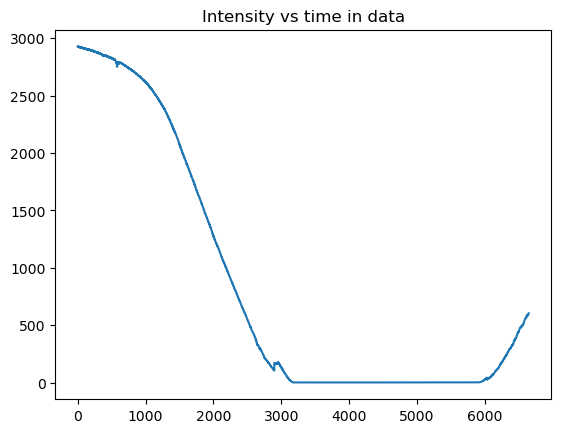

In [8]:
mean_intensity = np.array([np.mean(el) for el in data_array])

pl.plot(mean_intensity)
pl.title("Intensity vs time in data")

### 2.0 Show the flatfield for the observation

(1024, 1280)


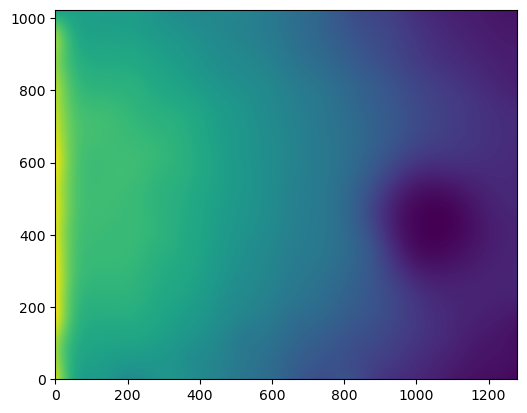

recomputing Uniform grid
(30, 1000)


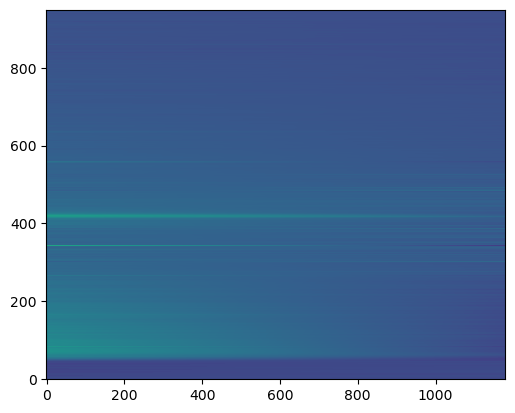

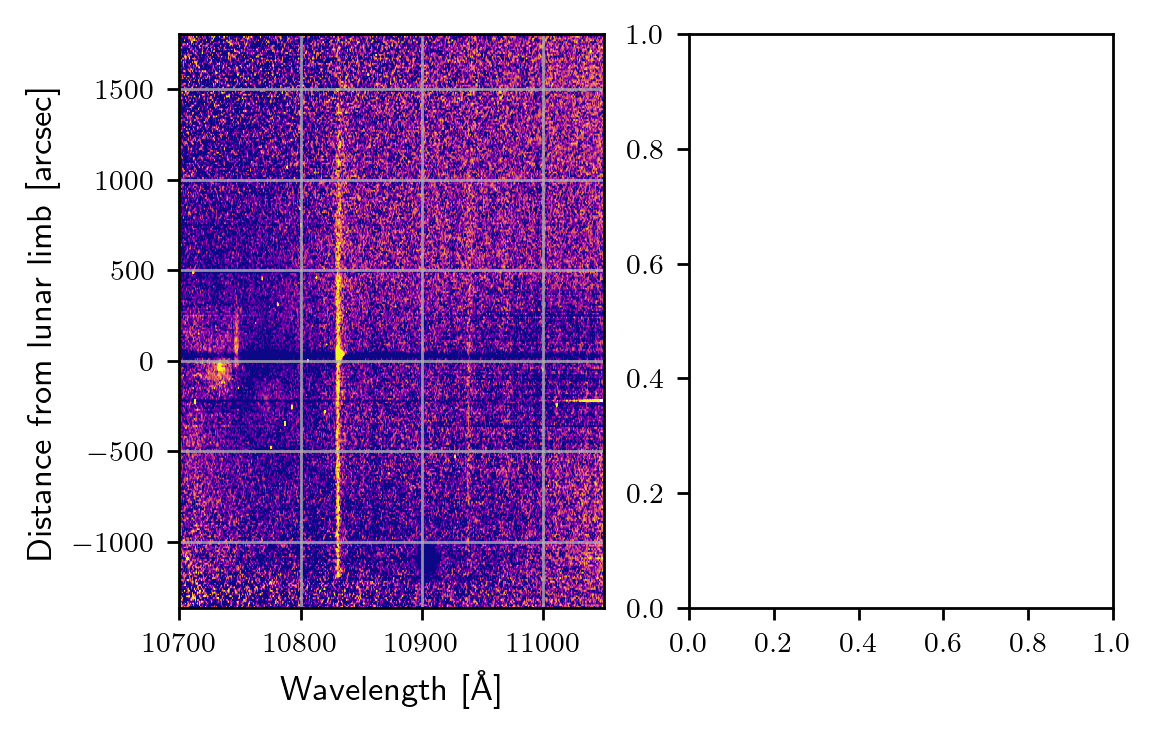

In [10]:
rotAngle = 0.95

summed_data = np.sum(data_array[5900:6025, :, :], axis=0)
print(summed_data.shape)

# result_3 = gaussian(summed_data, sigma=40)
flatField = gaussian(data_array[6035, :, :], sigma=40)
pl.imshow(flatField, origin="lower")
pl.show()

def line(x, a, b):
        return a*x + b

def fit_line(x, y):
    popt, pcov = opt.curve_fit(line, x, y)
    return popt

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def fit_parabola(x, y):
    popt, pcov = opt.curve_fit(parabola, x, y)
    return popt
summed_data /= flatField
summed_data = rotate(summed_data, angle=rotAngle)


summed_data = spectrum(summed_data, [30, 1000])

summed_data.loadDispersionGrid(inputName="/Users/memolnar//Work/Hanle_CME_Bz/CHEESE_data/24_04_08_Eclipse_data/dispersion_file.npz")
summed_data.recomputeUniformGrid()


ffContinuum = np.zeros((summed_data.spectrumUniform.shape[0], 2))
offset = 0
xx = np.linspace(0, summed_data.spectrumUniform.shape[1]-1, 
                    num=summed_data.spectrumUniform.shape[1]-offset)

for el in range(summed_data.spectrumUniform.shape[0]):
    ffContinuum[el, :] = fit_line(xx, summed_data.spectrumUniform[el, :])
    # ffContinuum[el, :] = fit_parabola(xx, summed_data.spectrumUniform[el, 
    #                                                                   int(offset//2):-1*int(offset//2)])
    
ffContinuum.shape
ffContinuumImage = np.array([line(xx, el[0], el[1])
                             for el in ffContinuum])
pl.imshow(ffContinuumImage, origin="lower")

fig_width_pt = 347  # Get this from LaTeX using \show\the\columnwidth
inches_per_pt = 1.0 / 72               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0) / 2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.labelsize': 10,
        #   'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size}
mp.rcParams.update(params)


fig, ax = pl.subplots(1, 2, dpi=250)
data_av = (summed_data.spectrumUniform)
imdata = data_av[:, :] / ffContinuumImage
imdata = downscale_local_mean(imdata, (3, 1))

im1 = ax[0].imshow(imdata, origin="lower",
                norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                      vmin = np.nanquantile(imdata, 0.35),),
                cmap="plasma", aspect="auto",
                extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1],
                          -462*summed_data.plateScale+220, 
                          462*summed_data.plateScale+220])
ax[0].set_xlabel("Wavelength [\\AA]")
ax[0].set_ylabel("Distance from lunar limb [arcsec]")
ax[0].set_xlim(10700, 11050)
ax[0].grid(alpha=0.8)

# pl.savefig("/Users/mmolnar/Writing/Papers/2024b_Molnar_Eclipse_results/eclipse_paper/figures/CHEESE_results_1.png")

### 2.1 Show the detected lines

#### 2.1.1 He I 1083

(317, 1180)
(1180,)


/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/2122907423.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 1204.86x744.645 with 3 Axes> than <Figure size 481.944x297.858 with 1 Axes> which fig.colorbar is called on.
  pl.colorbar(im1)


(10800.0, 10850.0)

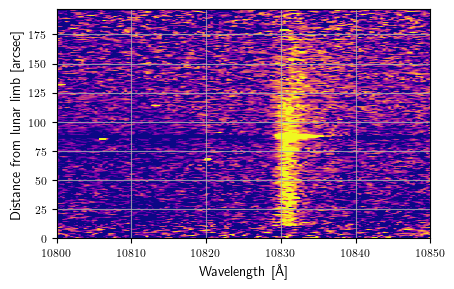

In [11]:
print(imdata.shape)
print(summed_data.lambdaUniform.shape)

pl.imshow(imdata,
          origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                             vmin = np.nanquantile(imdata, 0.35)),
          cmap="plasma", aspect="auto",
          extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1], 0, 1180/6])
                    # -462*summed_data.plateScale+220, 
                    # 462*summed_data.plateScale+220])
pl.xlabel("Wavelength [\\AA]")
pl.ylabel("Distance from lunar limb [arcsec]")
pl.xlim(10700, 11050)
pl.grid(alpha=0.8)
pl.colorbar(im1)
pl.xlim(10800, 10850)

#### 2.1.2 Fe XIII 1074

/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/1223775617.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 1204.86x744.645 with 4 Axes> than <Figure size 481.944x297.858 with 1 Axes> which fig.colorbar is called on.
  pl.colorbar(im1)


(10730.0, 10790.0)

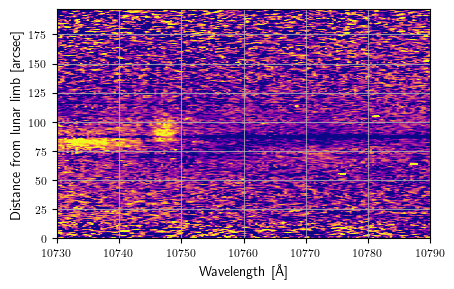

In [12]:
pl.imshow(imdata,
          origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.95),
                                    vmin = np.nanquantile(imdata, 0.25),),
          cmap="plasma", aspect="auto",
          extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1], 0, 1180/6])
                    # -462*summed_data.plateScale+220, 
                    # 462*summed_data.plateScale+220])
pl.xlabel("Wavelength [\\AA]")
pl.ylabel("Distance from lunar limb [arcsec]")
pl.xlim(10700, 11050)
pl.grid(alpha=0.8)
pl.colorbar(im1)
pl.xlim(10730, 10790)

#### 2.1.1 H I 1094 (Paschen-gamma)

/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/2547313306.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 1204.86x744.645 with 5 Axes> than <Figure size 481.944x297.858 with 1 Axes> which fig.colorbar is called on.
  pl.colorbar(im1)


(10900.0, 10950.0)

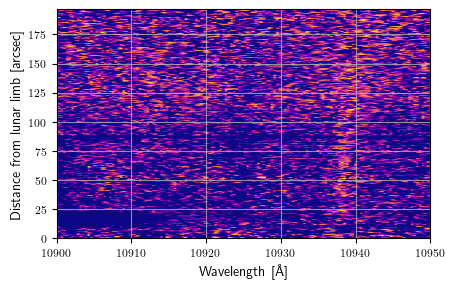

In [13]:
pl.imshow(imdata,
          origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                             vmin = np.nanquantile(imdata, 0.45),),
          cmap="plasma", aspect="auto",
          extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1], 0, 1180/6])
                    # -462*summed_data.plateScale+220, 
                    # 462*summed_data.plateScale+220])
pl.xlabel("Wavelength [\\AA]")
pl.ylabel("Distance from lunar limb [arcsec]")
pl.xlim(10700, 11050)
pl.grid(alpha=0.8)
pl.colorbar(im1)
pl.xlim(10900, 10950)

### 2.3 Apply the dispersion correction from the calibration data

In [17]:
lambdaFitRangesDict = {}
wavelengths = [10828, 10833, 10745, 10750, 10936, 10940]
newLambdaGrid = summed_data.lambdaUniform[:]
for el in wavelengths:
    lambdaFitRangesDict[el] = np.argmin(np.abs(newLambdaGrid - el))    

print(lambdaFitRangesDict)


{10828: 424, 10833: 438, 10745: 194, 10750: 208, 10936: 724, 10940: 735}


In [18]:
# model = models.Voigt1D(x_0=10830, 
#                        amplitude_L=1, 
#                        fwhm_G=0.5, fwhm_L=.1,
#                        bounds={"x_0":(10828, 10831.4),
#                                "fwhm_G":(1e-3, 2),
#                                "fwhm_L":(1e-3, 1)}) + models.Const1D(amplitude=0.8, 
#             

def Gaussian(x, mean, sigma, amplitude):
    return amplitude*np.exp(-0.5*(x - mean)**2 / sigma**2) /(sigma * np.sqrt(np.pi * 2))

def model(x, mean, sigma, amplitude, background):
    return Gaussian(x, mean, sigma, amplitude) + background

# model = (models.Gaussian1D(mean=10830, 
#                           amplitude=1, 
#                           stddev=1.5,
#                           bounds={"mean":(10827, 10832),
#                                    "stddev":(0.5, 2)}) + models.Const1D(amplitude=0.8, 
#                                                                         bounds={"amplitude":(0.8, 1.2)}))

from scipy.optimize import curve_fit



fits_He1083 = [] 
cov_matrices_He1083 = [] 
fits_Fe1074 = []
cov_matrices_Fe1074 = []
fits_HI1093 = []
cov_matrices_HI1093 = []

for el in range(imdata.shape[0]):
    
    x_He1083 = newLambdaGrid[lambdaFitRangesDict[10828]:lambdaFitRangesDict[10833]]
    x_Fe1074 = newLambdaGrid[lambdaFitRangesDict[10745]:lambdaFitRangesDict[10750]]
    x_HI1093 = newLambdaGrid[lambdaFitRangesDict[10936]:lambdaFitRangesDict[10940]]

    try:
        fit, cov_matrix = curve_fit(model, x_He1083, imdata[el, lambdaFitRangesDict[10828]:lambdaFitRangesDict[10833]],
                                    p0=[10830, 1.0, 1, 0.8], sigma = np.ones(len(x_He1083))*0.3, 
                                    absolute_sigma=True, 
                                    bounds=([10829, 0.1, 0.2, 0.7], [10832, 1.5, 10, 1.2]))
    except:
        fit = np.zeros(4) 
    fits_He1083.append(fit)
    cov_matrices_He1083.append(cov_matrix)

    try:
        fit, cov_matrix = curve_fit(model, x_Fe1074, imdata[el, lambdaFitRangesDict[10745]:lambdaFitRangesDict[10750]],
                                    p0=[10748, 1.0, 1, 0.8], sigma = np.ones(len(x_Fe1074))*0.3, 
                                    absolute_sigma=True, 
                                    bounds=([10746, 0.1, 0.2, 0.7], [10749, 1.5, 4, 1.2]))
    except:
        fit = np.zeros(4)
        
    fits_Fe1074.append(fit)
    cov_matrices_Fe1074.append(cov_matrix)

    try:
        fit, cov_matrix = curve_fit(model, x_HI1093, imdata[el, lambdaFitRangesDict[10936]:lambdaFitRangesDict[10940]],
                                    p0=[10938, 1.0, 1, 0.8], sigma = np.ones(len(x_HI1093))*0.3, 
                                    absolute_sigma=True, 
                                    bounds=([10937, 0.2, 0.2, 0.7], [10939, 1.5, 2, 1.2]))
    except:
        fit = np.zeros(4)
    fits_HI1093.append(fit)
    cov_matrices_HI1093.append(cov_matrix)

cov_matrices_He1083 = np.array(cov_matrices_He1083)
cov_matrices_Fe1074 = np.array(cov_matrices_Fe1074)
cov_matrices_HI1093 = np.array(cov_matrices_HI1093)




In [19]:
perr = np.sqrt(np.diag(cov_matrix))

print(perr)

[0.20420442 0.18398336 0.24157042 0.10898837]


/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/1899013316.py:33: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.sqrt(np.array(cov_matrices_Fe1074))[:, 1, 1], label="Fe1074")
/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/1899013316.py:34: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.sqrt(np.array(cov_matrices_He1083))[:, 1, 1], label="He1083")
/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/1899013316.py:35: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.sqrt(np.array(cov_matrices_HI1093))[:, 1, 1], label="HI1093")


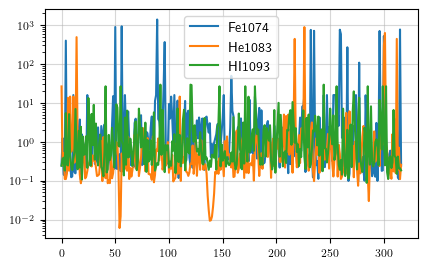

In [20]:
line_width_He1083 = []
line_width_Fe1074 = []
line_width_HI1093 = []

line_amplitude_He1083 = []
line_amplitude_Fe1074 = []
line_amplitude_HI1093 = []

for el in range(len(fits_Fe1074)):
    
    if np.sqrt(cov_matrices_He1083[el][1, 1]) > 0.25:
        line_width_He1083.append(-100)
    else:
        line_width_He1083.append(fits_He1083[el][1])
    
    if np.sqrt(cov_matrices_He1083[el][2, 2]) > 1.0:
        line_amplitude_He1083.append(-100)
    else:
        line_amplitude_He1083.append(fits_He1083[el][2])
    
    if np.sqrt(cov_matrices_Fe1074[el][1, 1]) > 0.45:
        line_width_Fe1074.append(-100)
    else:
        line_width_Fe1074.append(fits_Fe1074[el][1])


    
    if np.sqrt(cov_matrices_HI1093[el][1, 1]) > 0.03:
        line_width_HI1093.append(-100)
    else:
        line_width_HI1093.append(fits_HI1093[el][1])
        
pl.plot(np.sqrt(np.array(cov_matrices_Fe1074))[:, 1, 1], label="Fe1074")
pl.plot(np.sqrt(np.array(cov_matrices_He1083))[:, 1, 1], label="He1083")
pl.plot(np.sqrt(np.array(cov_matrices_HI1093))[:, 1, 1], label="HI1093")
pl.legend()
pl.yscale("log")
pl.grid(alpha=0.5)

(317, 1180)
(<Axes: >, 0)
(<Axes: >, 7)
(<Axes: >, 14)
(<Axes: >, 21)
(<Axes: >, 29)
(<Axes: >, 36)
(<Axes: >, 43)
(<Axes: >, 51)
(<Axes: >, 58)
(<Axes: >, 65)
(<Axes: >, 73)
(<Axes: >, 80)
(<Axes: >, 87)
(<Axes: >, 95)
(<Axes: >, 102)
(<Axes: >, 109)
(<Axes: >, 117)
(<Axes: >, 124)
(<Axes: >, 131)
(<Axes: >, 139)


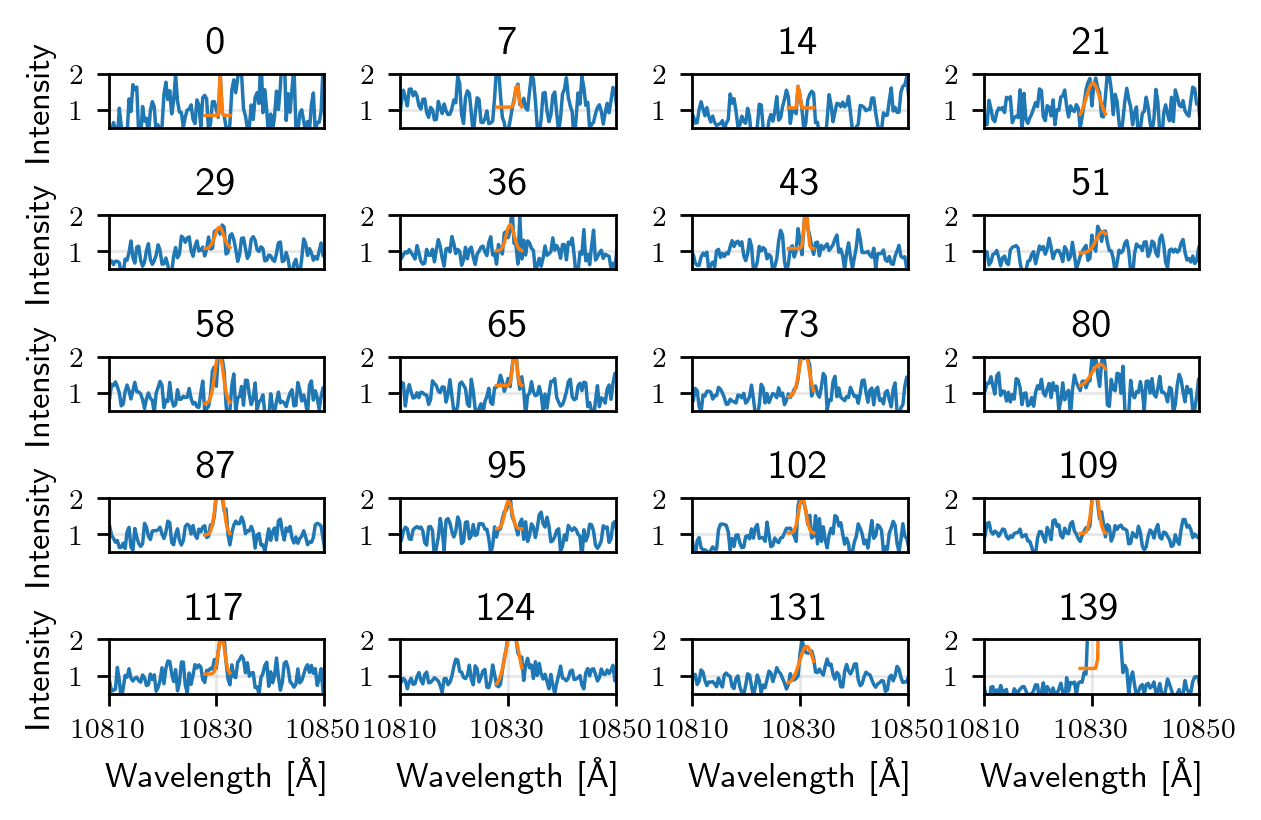

In [21]:
ncols = 4
nrows = 5
print(imdata.shape)

nPlots = ncols * nrows
rangeInd = np.linspace(0, 970//7 + 1, num=nPlots, dtype=int)

fig, ax = pl.subplots(nrows, ncols, dpi=250)

for el in zip(ax.flatten(), rangeInd):
        lambda_t = summed_data.lambdaUniform[lambdaFitRangesDict[10828]:lambdaFitRangesDict[10833]]
        print(el)
        el[0].plot(summed_data.lambdaUniform[:], 
                   imdata[el[1], :],
                   linewidth=1, label=f"{el[1]}")
        # el[0].plot(summed_data.lambdaUniform[lambdaFitRangesDict[10828]:lambdaFitRangesDict[10833]], 
        #            fits[el[1]](summed_data.lambdaUniform[lambdaFitRangesDict[10828]:lambdaFitRangesDict[10833]]),
        #            linewidth=1, label=f"Fit")
        el[0].plot(lambda_t, 
                   model(lambda_t, 
                         fits_He1083[el[1]][0], 
                         fits_He1083[el[1]][1], 
                         fits_He1083[el[1]][2], 
                         fits_He1083[el[1]][3]),
                   linewidth=1, label=f"Fit")


        el[0].set_title(f"{el[1]}")
for el in ax.flatten():         
        # el.legend()
        el.set_xlim(10810, 10850)
        el.set_ylim(.5, 2)
        el.grid(alpha=0.3)
        el.set_xticks([])


pl.tight_layout()

for el in ax[:, 0]:
        el.set_ylabel("Intensity")

for el in ax[-1, :]:
    el.set_xlabel("Wavelength [\\AA]")
    el.set_xticks(np.linspace(10810, 10850, num=3))



/var/folders/8n/b1dtjbc56x18z6fppp7h_7480000gp/T/ipykernel_74999/3438390610.py:160: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


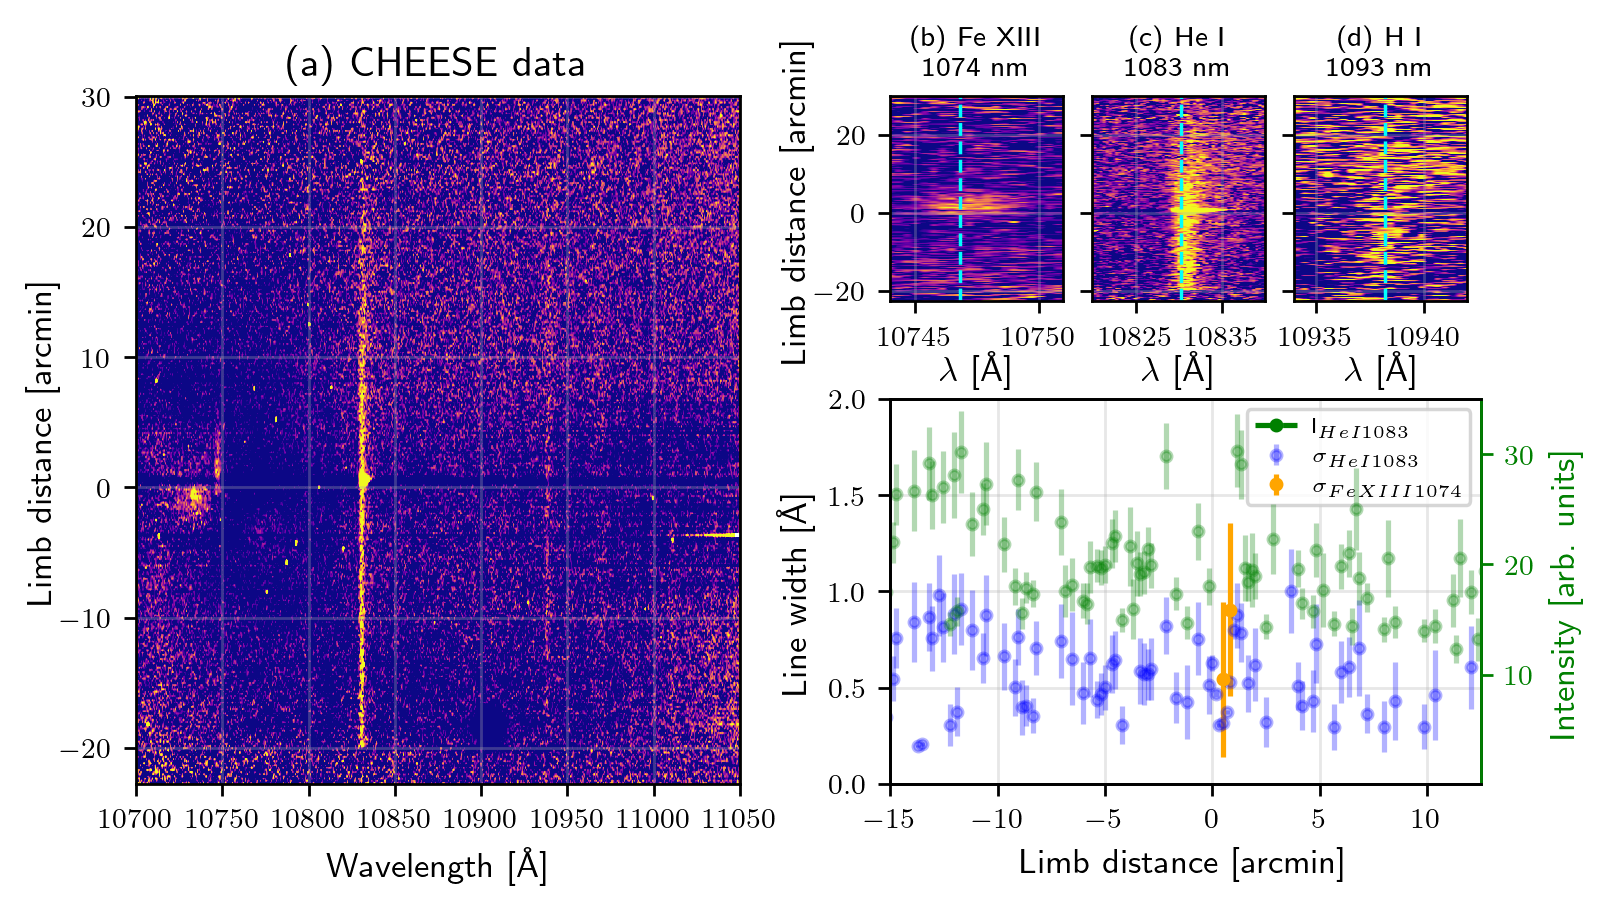

In [22]:
fig_width_pt = 347  # Get this from LaTeX using \show\the\columnwidth
inches_per_pt = 1.0/50           # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean  / 1.2    # height in inches
fig_size =  [fig_width,fig_height]

yrange_fig = [(-462*summed_data.plateScale+220) / 60, 
              (462*summed_data.plateScale+220) / 60]

numPoints = 100 # number of points for the line plots subplots 10, 11, 12

import matplotlib as mp

params = {'backend': 'ps',
          'axes.labelsize': 10,
        #   'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size}
mp.rcParams.update(params)

fig  = pl.figure(dpi=250, figsize=fig_size)

gs = fig.add_gridspec(100, 100)

ax0 = fig.add_subplot(gs[:, 0:45])
ax10 = fig.add_subplot(gs[0:30, 56:69])
ax11 = fig.add_subplot(gs[0:30, 71:84])
ax12 = fig.add_subplot(gs[0:30, 86:99])
ax20 = fig.add_subplot(gs[44:, 56:])


im1 = ax0.imshow(imdata, origin="lower",
                norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                      vmin = np.nanquantile(imdata, 0.55),),
                cmap="plasma", aspect="auto",
                extent = [summed_data.lambdaUniform[0], 
                          summed_data.lambdaUniform[-1],
                          yrange_fig[0], yrange_fig[1]])
ax0.set_xlabel("Wavelength [\\AA]")
ax0.set_ylabel("Limb distance [arcmin]",
                 labelpad=0)
ax0.set_xlim(10700, 11050)
ax0.grid(alpha=0.8)
ax0.set_title("(a) CHEESE data")

fontsize_suptitles = 8
ax10.set_title("(b) Fe XIII\n1074 nm", fontsize=fontsize_suptitles)
ax11.set_title("(c) He I\n1083 nm", fontsize=fontsize_suptitles)
ax12.set_title("(d) H I\n1093 nm", fontsize=fontsize_suptitles)

ax10.imshow(imdata,
            origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                    vmin = np.nanquantile(imdata, 0.35),),
            cmap="plasma", aspect="auto",
            extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1],
                      yrange_fig[0], yrange_fig[1]])
ax10.plot(np.linspace(10746.8, 10746.8, num=numPoints), 
          np.linspace(yrange_fig[0], yrange_fig[1], num=numPoints),
          '--', color = 'cyan', linewidth=1)
ax10.set_ylabel("Limb distance [arcmin]",
                 labelpad=0)
ax10.set_xlim(10744, 10751)
# ax[0].colorbar(im1)

ax11.imshow(imdata,
          origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.99),
                                    vmin = np.nanquantile(imdata, 0.35),),
          cmap="plasma", aspect="auto",
          extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1],
                    yrange_fig[0], yrange_fig[1]])
ax11.plot(np.linspace(10830.2, 10830.2, num=numPoints), 
          np.linspace(yrange_fig[0], yrange_fig[1], num=numPoints),
          '--', color = 'cyan', linewidth=1)
ax11.set_xlim(10820, 10840)

ax12.imshow(imdata,
            origin="lower",norm=colors.LogNorm(vmax = np.nanquantile(imdata, 0.9),
                                    vmin = np.nanquantile(imdata, 0.5),),
            cmap="plasma", aspect="auto",
            extent = [summed_data.lambdaUniform[0], summed_data.lambdaUniform[-1],
                      yrange_fig[0], yrange_fig[1]])
ax12.set_xlim(10934, 10942)
ax12.plot(np.linspace(10938.17, 10938.17, num=numPoints), 
          np.linspace(yrange_fig[0], yrange_fig[1], num=numPoints),
          '--', color = 'cyan', linewidth=1)
ax_arr = [ax0, ax10, ax11, ax12]

xaxis_widths_1083 = np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_width_He1083))
xaxis_widths_1074 = np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_width_Fe1074))
xaxis_amplitude_1083 = np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_amplitude_He1083))

range_1074 = np.where(np.abs(xaxis_widths_1074 -0.5) < 1)

# line_width_He1083_runav = moving_average(line_width_He1083, n=5) 

ax20.errorbar(xaxis_widths_1083,
              line_width_He1083,
              yerr=np.sqrt(cov_matrices_He1083[:, 1, 1]),
              fmt='.', label="$\\sigma_{HeI1083}$", color="blue", alpha=0.3)

# ax20.plot(xaxis_widths_1083[2:-2],
#           line_width_He1083_runav, linestyle='--',
#           label="$\\sigma_{HeI1083}$", color="blue")

ax20.errorbar(xaxis_widths_1074[range_1074],
              np.array(line_width_Fe1074)[range_1074], 
              yerr=np.sqrt(cov_matrices_Fe1074[range_1074, 1, 1]), fmt='.', 
              label="$\\sigma_{FeXIII1074}$", color="orange")
              
# # ax20.errorbar(np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_width_HI1093)),
#               line_width_HI1093, yerr=np.sqrt(cov_matrices_HI1093[:, 1, 1]), fmt='.', 
#               label="H I 1093")
ax20.plot(-100, -100, 'g.--', label="I$_{HeI1083}$")

ax20.set_xlabel("Limb distance [arcmin]")
ax20.set_ylabel("Line width [{\\AA}]")
ax20.legend(fontsize=fontsize_suptitles-2)

ax20.set_xlim(-15, 12.5) 
ax20.grid(alpha=0.3)
ax20.set_ylim(0., 2)

ax20_twin = ax20.twinx()


line_int_He1083 = line_amplitude_He1083*(np.ones(len(line_amplitude_He1083))*6) + np.ones(len(line_amplitude_He1083))*10
# line_int_He1083_runav = moving_average(line_int_He1083, n=5) 

ax20_twin.errorbar(np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_amplitude_He1083)),
                   line_int_He1083,
                   yerr=np.sqrt(cov_matrices_He1083[:, 2, 2])*(np.ones(len(line_amplitude_He1083))*4.0),
                   fmt='g.', alpha=0.3)
# ax20_twin.plot(np.linspace(yrange_fig[0], yrange_fig[1], num=len(line_int_He1083_runav)),
#                line_int_He1083_runav, linestyle='--', color='green')

ax20_twin.set_ylim(0.1, 35)
ax20_twin.set_ylabel("Intensity [arb. units]", color="green")
ax20_twin.tick_params(axis='y', labelcolor='green', color="green")
# Optionally, change the color of the right spine
ax20_twin.spines['right'].set_color('green')


for el in ax_arr+[ax20]: 
  el.grid(alpha=0.3)

for el in ax_arr[1:4]:
  el.set_xlabel("$\\lambda$ [\\AA]",
                labelpad=0)

for el in ax_arr[2:4]:
  el.set_yticklabels([])

ax11.set_xticks([10825, 10835])


pl.tight_layout()

pl.savefig("/Users/memolnar/Writing/Papers/2025a_Molnar_Eclipse_results/eclipse_paper_v2/eclipse_paper/figures/CHEESE_results_2.svg", 
           format="svg")
pl.show() 